In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

t0 = time.time()

# 1. Installation `pyspark`

In [2]:
pip install pyspark

     |████████████████████████████████| 204.2 MB 28 kB/s s eta 0:00:01
     |████████████████████████████████| 198 kB 34.3 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612244 sha256=1024adc599db043aabc2b816ba24895f9c6ce0c1039efb735bd2a7fc0470817a
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


#### Import libraries

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
print('Installation takes %s seconds'%(time.time() - t0))

Installation takes 38.64375901222229 seconds


#### Build-in a spark-session

In [4]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("Word Count") \
                    .config("spark.some.config.option", "some-value") \
                    .getOrCreate()
spark

In [5]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

#### Loading `csv.file` with `pandas`

In [6]:
mvm_df = pd.read_csv(r'../input/big-data-vers-1/movement.csv')
mvm_df.head()

,ad_id,latitude,longitude,horizontal_accuracy,id_type,utc_timestamp,geo_hash,ip_address
0,0001614a-2664-4297-905a-bb79851f4576,35.466200,-97.51680,89.0,aaid,1598273356,9y69ubqmt,107.242.113.53
1,0001c560-b875-4b9b-b128-745a53a6be43,61.151929,-149.98078,15.0,aaid,1598232603,bdv7gh77f,107.77.205.227
2,0001c560-b875-4b9b-b128-745a53a6be43,61.151919,-149.98077,5.0,aaid,1598232630,bdv7gh77d,107.77.205.227
3,0001c560-b875-4b9b-b128-745a53a6be43,61.151919,-149.98077,10.0,aaid,1598232631,bdv7gh77d,107.77.205.227
4,0001c560-b875-4b9b-b128-745a53a6be43,61.151929,-149.98078,10.0,aaid,1598232642,bdv7gh77f,107.77.205.227


#### Loading `csv.data` to `spark` & viewing by `pandas`

In [7]:
movement_df = spark.read.format("csv").option("header", "true").load(r'../input/big-data-vers-1/movement.csv')
movement_df.toPandas().head()

,ad_id,latitude,longitude,horizontal_accuracy,id_type,utc_timestamp,geo_hash,ip_address
0,0001614a-2664-4297-905a-bb79851f4576,35.4662,-97.5168,89.0,aaid,1598273356,9y69ubqmt,107.242.113.53
1,0001c560-b875-4b9b-b128-745a53a6be43,61.151929,-149.98078,15.0,aaid,1598232603,bdv7gh77f,107.77.205.227
2,0001c560-b875-4b9b-b128-745a53a6be43,61.151919,-149.98077,5.0,aaid,1598232630,bdv7gh77d,107.77.205.227
3,0001c560-b875-4b9b-b128-745a53a6be43,61.151919,-149.98077,10.0,aaid,1598232631,bdv7gh77d,107.77.205.227
4,0001c560-b875-4b9b-b128-745a53a6be43,61.151929,-149.98078,10.0,aaid,1598232642,bdv7gh77f,107.77.205.227


#### Register the `loaded-dataframe` as table in `SQL`

In [8]:
t0 = time.time()
SQLContext.registerDataFrameAsTable(sc, df = movement_df, tableName = 'movement')  #or using visiting_df.createGlobalTempView(table_names[k])
print('Attach table "movement" takes %s seconds'%(time.time() - t0))

Attach table "movement" takes 0.2147207260131836 seconds


# 2. Cleaning data.`table: movement`
When using data, most people agree that your insights and analysis are only as good as the data you are using. Essentially, garbage data in is garbage analysis out. Data cleaning, also referred to as data cleansing and data scrubbing, is one of the most important steps for your organization if you want to create a culture around quality data decision-making.


#### Definition.
Data cleaning is the process of fixing or removing incorrect, corrupted, incorrectly formatted, duplicate, or incomplete data within a dataset.

When combining multiple data sources, there are many opportunities for data to be duplicated or mislabeled. If data is incorrect, outcomes and algorithms are unreliable, even though they may look correct. There is no one absolute way to prescribe the exact steps in the data cleaning process because the processes will vary from dataset to dataset. But it is crucial to establish a template for your data cleaning process so you know you are doing it the right way every time.

## 2.1. Fix structural errors
Structural errors are when you measure or transfer data and notice strange naming conventions, typos, or incorrect capitalization. These inconsistencies can cause mislabeled categories or classes. For example, you may find `“N/A”` and `“Not Applicable”` both appear, but they should be analyzed as the same category.

**Step 1. Viewing the structure at each column**

In [9]:
t0 = time.time()
mvm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ad_id                1000000 non-null  object 
 1   latitude             1000000 non-null  float64
 2   longitude            1000000 non-null  float64
 3   horizontal_accuracy  1000000 non-null  float64
 4   id_type              1000000 non-null  object 
 5   utc_timestamp        1000000 non-null  int64  
 6   geo_hash             1000000 non-null  object 
 7   ip_address           629854 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 61.0+ MB


Hence, in this database,
- 1) first, we will change the `type: int64` from `utc_timestamp` to `datetime`
- 2) Next, convert `ip_address` to the `valid_ip_address` by replace `NaN` to `unknown (or 0)` and remove `,` or `;` if they appear in the `ip_address`

### Filling the missing value

In [10]:
import datetime
mvm_df['utc_timestamp'] = mvm_df['utc_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
mvm_df['ip_address'] = mvm_df['ip_address'].fillna('0')
mvm_df.head()

,ad_id,latitude,longitude,horizontal_accuracy,id_type,utc_timestamp,geo_hash,ip_address
0,0001614a-2664-4297-905a-bb79851f4576,35.466200,-97.51680,89.0,aaid,2020-08-24 12:49:16,9y69ubqmt,107.242.113.53
1,0001c560-b875-4b9b-b128-745a53a6be43,61.151929,-149.98078,15.0,aaid,2020-08-24 01:30:03,bdv7gh77f,107.77.205.227
2,0001c560-b875-4b9b-b128-745a53a6be43,61.151919,-149.98077,5.0,aaid,2020-08-24 01:30:30,bdv7gh77d,107.77.205.227
3,0001c560-b875-4b9b-b128-745a53a6be43,61.151919,-149.98077,10.0,aaid,2020-08-24 01:30:31,bdv7gh77d,107.77.205.227
4,0001c560-b875-4b9b-b128-745a53a6be43,61.151929,-149.98078,10.0,aaid,2020-08-24 01:30:42,bdv7gh77f,107.77.205.227


#### 2.1.2) Vefify `ip_address` is valid?
We have 2 types of `valid IP`: `IPv4` and `IPv6` (see [link](https://leetcode.com/problems/validate-ip-address/) )

**IPv4** An `valid IP_address` must:

- Include `4 parts` and all the values of these parts must be an integers from `0` to `255`
- Each part be seperated by the `dot .`, not commas `,` or any characters like: `; - _ etc`
- Example, `107.242.113.53`

**IPv6** must
- Include `8 parts` seperated by `:`, and length of each parts is less than 4 for all parts.
- Each part is a `hexadecimal` string which may contain `digits`, `lower-case` English letter ('a' to 'f') and `upper-case` English letters ('A' to 'F').
- For example `'2607:fb90:21d6:4e82:942a:4fe0:81c3:73b0'`


In [11]:
import string

def valid_IP4(address):
    parts = address.split(".")
    if len(parts) != 4:
        return False
    for item in parts:
        if not 0 <= int(item) <= 255:
            return False
    return True

def valid_IP6(address):
    parts = address.split(":")
    if len(parts) == 8:
        for item in parts:
            if len(item) <= 4:
                if all(s in string.hexdigits for s in item):
                    return True
    else:
        return False
    
def ip_type(address):
    if valid_IP4(address):
        return 'IPv4'
    elif valid_IP6(address):
        return 'IPv6'
    elif address == '0':
        return 'unknown_ip'
    else:
        return 'invalid_ip'

In [12]:
print('check valid_IPv4 (197.255.01.01):', valid_IP4('197.255.01.01'))
print('check valid_IPv6 (2607:fb90:21d6:4e82:942a:4fe0:81c3:73b0):', valid_IP6('2607:fb90:21d6:4e82:942a:4fe0:81c3:73b0'))

check valid_IPv4 (197.255.01.01): True
check valid_IPv6 (2607:fb90:21d6:4e82:942a:4fe0:81c3:73b0): True


In [13]:
mvm_df['ip_valid'] = mvm_df['ip_address'].apply(lambda x: ip_type(str(x)))
mvm_df.head()

,ad_id,latitude,longitude,horizontal_accuracy,id_type,utc_timestamp,geo_hash,ip_address,ip_valid
0,0001614a-2664-4297-905a-bb79851f4576,35.466200,-97.51680,89.0,aaid,2020-08-24 12:49:16,9y69ubqmt,107.242.113.53,IPv4
1,0001c560-b875-4b9b-b128-745a53a6be43,61.151929,-149.98078,15.0,aaid,2020-08-24 01:30:03,bdv7gh77f,107.77.205.227,IPv4
2,0001c560-b875-4b9b-b128-745a53a6be43,61.151919,-149.98077,5.0,aaid,2020-08-24 01:30:30,bdv7gh77d,107.77.205.227,IPv4
3,0001c560-b875-4b9b-b128-745a53a6be43,61.151919,-149.98077,10.0,aaid,2020-08-24 01:30:31,bdv7gh77d,107.77.205.227,IPv4
4,0001c560-b875-4b9b-b128-745a53a6be43,61.151929,-149.98078,10.0,aaid,2020-08-24 01:30:42,bdv7gh77f,107.77.205.227,IPv4


#### How many `invalid ip_address`??

In [14]:
mvm_df.groupby('ip_valid').count()[['ip_address']].sort_values(by = 'ip_address', ascending=False)

,ip_address
ip_valid,
IPv4,629723
unknown_ip,370146
invalid_ip,82
IPv6,49


#### Viewing the `invalid_ip`

In [15]:
mvm_df[mvm_df['ip_valid'] == 'invalid_ip'].head()

,ad_id,latitude,longitude,horizontal_accuracy,id_type,utc_timestamp,geo_hash,ip_address,ip_valid
38178,01259090-d65e-47c6-a6ee-c3e184bd6f87,33.939330,-118.406740,65.000000,idfa,2020-08-24 02:51:23,9q5c1d6yf,2600:387:8:5::4b,invalid_ip
38179,01259090-d65e-47c6-a6ee-c3e184bd6f87,33.941620,-118.406900,8.866743,idfa,2020-08-24 02:56:17,9q5c1dfsr,2600:387:8:5::4b,invalid_ip
38180,01259090-d65e-47c6-a6ee-c3e184bd6f87,33.969580,-118.373260,7.641668,idfa,2020-08-24 03:24:16,9q5c4rgpp,2600:387:8:5::4b,invalid_ip
128988,034d76bb-a577-4d10-a369-cb75ee008091,30.425069,-84.367769,8.000000,idfa,2020-08-24 22:07:40,djkj04tqb,2601:4c3:200::,invalid_ip
205307,05300836-3d0c-4eec-a0a6-9b761cb20121,34.799618,-82.572083,10.800000,idfa,2020-08-24 03:32:01,dnjmcp0f7,2600:6c5e:137f::,invalid_ip


Hence, this is enough and no important to process the `ip_address` anymore.

## 2.2. Remove duplicate or irrelevant observations
### 2.2.1. Duplicate observations
Remove unwanted observations from your dataset, including duplicate observations or irrelevant observations. Duplicate observations will happen most often during data collection. When you :
- combine data sets from multiple places, 
- scrape data, or receive data from clients or multiple departments, there are opportunities to create duplicate data. 

De-duplication is one of the largest areas to be considered in this process.

In `Python`, `an` observation is corresponding to the `row in DataFrame table`, hence: you can use the function `dataframe.drop_duplicates()` from `pandas` to solve this process.

In [16]:
print('Data-dimension; before drop_duplicates:', mvm_df.shape)
mvm_df.drop_duplicates(inplace = True)
print('Data-dimension; after drop_duplicates:', mvm_df.shape)

Data-dimension; before drop_duplicates: (1000000, 9)
Data-dimension; after drop_duplicates: (1000000, 9)


$\qquad \Rightarrow$ Hence, there is not any `duplicated row` in this dataset.

### 2.2.2. Irrelevant observations
`Irrelevant observations` are when you notice observations that do not fit into the **specific problem** you are trying to analyze. 

For example, 
- If you want to analyze data regarding `millennial customers`, but your dataset includes `older generations`, you might remove those `irrelevant observations`. This can make analysis more efficient and minimize distraction from your primary target—as well as creating a more manageable and more performant dataset.

- If you were building a model for `Single-Family` homes only, you wouldn't want observations for `Apartments` in there.

Checking for `irrelevant observations` before `engineering features` can save you many headaches down the road.

==> We can see that, 
- i) All the `latitude` and `longitude` is valid (from `-180` to `180`) when displaying on the World-map. Hence, nothing to remove with these columns.

50.358054876327515


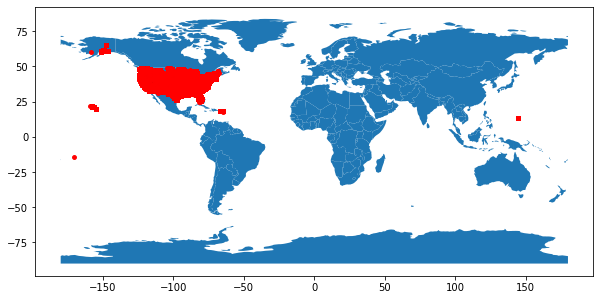

In [17]:
t0 = time.time()

geometry = [Point(xy) for xy in zip(mvm_df['longitude'], mvm_df['latitude'])]
gdf = GeoDataFrame(mvm_df[['latitude', 'longitude']], geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

print(time.time() - t0)

- ii) The `horizontal_accuracy` is between `0` and `100`. Now look at the following table

In [18]:
mvm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,1000000.0,36.876742,5.409621,-14.278107,33.137965,37.263948,40.917809,64.896777
longitude,1000000.0,-90.269102,13.820148,-170.702500,-96.153293,-87.161509,-81.151303,144.758762
horizontal_accuracy,1000000.0,18.657753,24.173314,1.000000,5.800000,10.000000,19.000000,499.000000


Hence, we must remove all the `horozontal_accuracy` which be larger than 100.

In [19]:
mvm_df = mvm_df[mvm_df['horizontal_accuracy'] <= 100]
mvm_df.shape

(988695, 9)

So there are more than 11000 values is invalid at the columns `horizontal_accuracy`

- iii) For another columns:

$\qquad \diamond$ For `id_type`, we only have 2 types `aaid` and `idfa` and this is not important to change the format in this column.

In [20]:
 mvm_df.groupby('id_type').count()[['ad_id']]

,ad_id
id_type,
aaid,512590
idfa,476105


$\qquad \diamond$ For `ip_address` & `ip_valid`, we had processed before and hence we only remain focus on the last column: `geo_hash`.

To understand "which `geohash` values is valid", you can refer [wikipedia](https://en.wikipedia.org/wiki/Geohash)

In [21]:
query = spark.sql("""
                        SELECT geo_hash, LENGTH(geo_hash) AS len_geo_hash
                        FROM movement                     
                 """)
query.toPandas().groupby('len_geo_hash').count()[['geo_hash']]

,geo_hash
len_geo_hash,
9,1000000


So, firstly, by `df.info()` we had known that `geo_hash` is the `text-type` and now we can state that all of them has the length of 9 characters

## 2.3. Check the outlier.

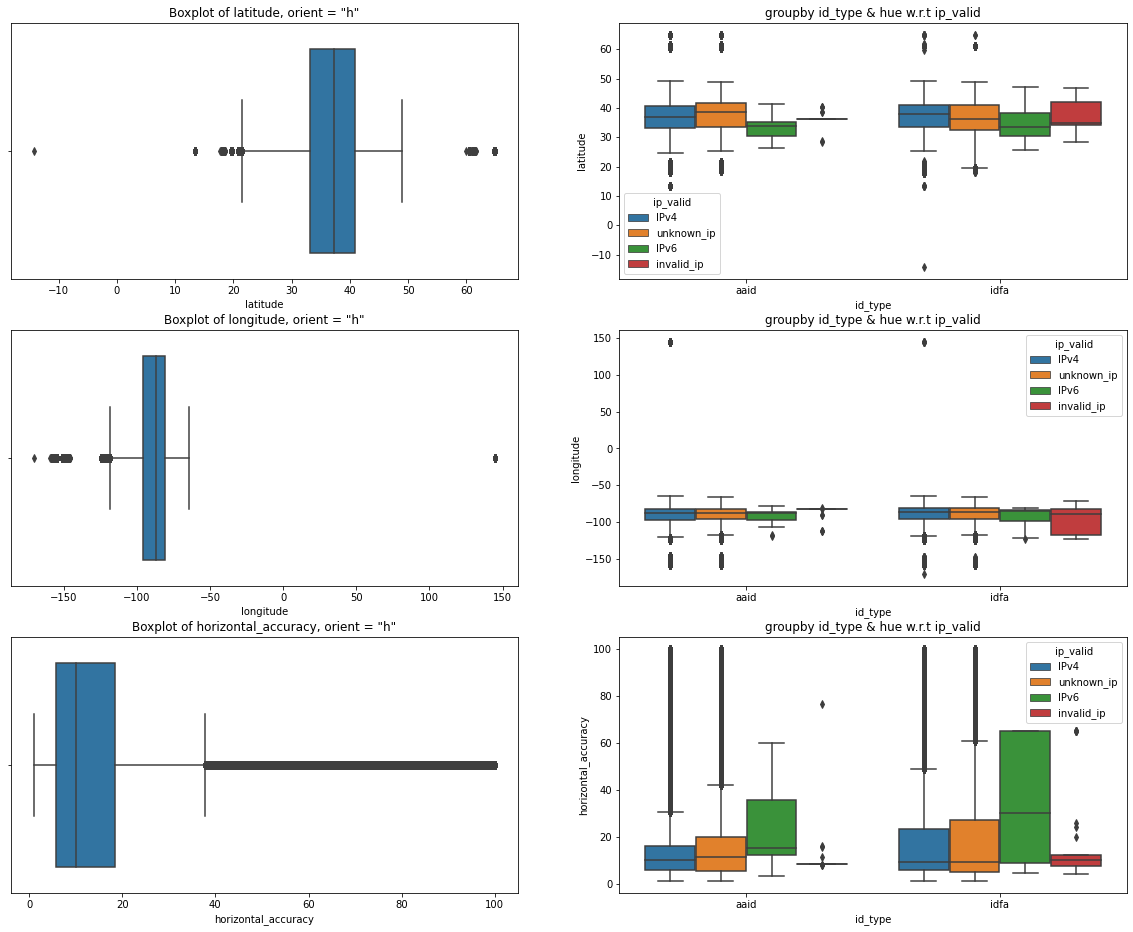

In [22]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 16))
ax = ax.ravel()
for k, y in enumerate(['latitude', 'longitude', 'horizontal_accuracy']):
    sns.boxplot(y = y, orient = 'h', data = mvm_df, ax = ax[2*k])
    ax[2*k].set_title('Boxplot of %s, orient = "h"'%(y))
    sns.boxplot(x = 'id_type', y = y, hue = 'ip_valid', data = mvm_df, ax = ax[2*k + 1])
    ax[2*k+1].set_title('groupby id_type & hue w.r.t ip_valid')